In [1]:
from pyscancf import pyscancf as pcf

Importing Libraries

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Importing Libraries Done


In [2]:
import pyart
import glob
import xarray as xr
import wradlib as wrl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Lets create cf/radial data by using pyscancf

In [ ]:
pcf.cfrad('MUM150615IMD','output',gridder=False)

### Now the data has been created, lets use pyart for testing polar data first

In [3]:
radar = pyart.io.read_cfradial('output/polar_MUM150615000342.nc')

In [4]:
display = pyart.graph.RadarDisplay(radar)

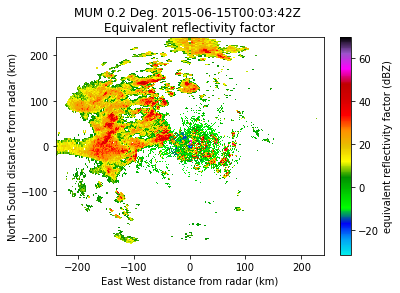

In [5]:
display.plot('REF',cmap='pyart_NWSRef')

In [76]:
#radar.info()

### Now lets convert the polar data to grids by using pyscancf, here only one file is converted

In [6]:
pfiles = sorted(glob.glob('output/polar*000*nc'))
print(len(pfiles))

1


In [7]:
for file in pfiles:
    radar = pyart.io.read_cfradial(file)
    grid = pcf.get_grid(radar)
    grid.write('output/grid_'+file.split('_')[-1])

### Now we created the gridded file, lets analyze it with pyart and xarray

In [8]:
grid = pyart.io.read_grid('output/grid_MUM150615000342.nc')

#### pyart's grid display function

In [9]:
grid_display = pyart.graph.GridMapDisplay(grid)

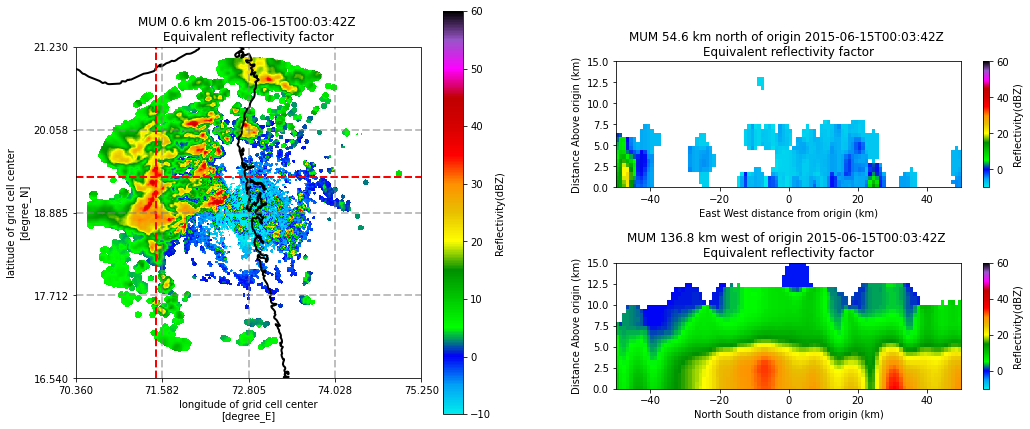

In [10]:
grid_display = pyart.graph.GridMapDisplay(grid)

# Setting projection, figure size, and panel sizes.
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[15, 7])

map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Set parameters.
level = 1
vmin = -10
vmax = 60
lat = 19.385
lon = 71.5
cmap='pyart_NWSRef'

# Panel 1: PPI plot of the second tilt.
ax1 = fig.add_axes(map_panel_axes, projection=projection)
grid_display.plot_grid('REF', 1, vmin=vmin, vmax=vmax,
                  projection=projection,
                  cmap=cmap)
grid_display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2: longitude slice
ax2 = fig.add_axes(x_cut_panel_axes)
grid_display.plot_longitude_slice('REF', lon=lon, lat=lat,
                             vmin=vmin, vmax=vmax,
                             cmap=cmap)

ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])

# Panel 3: latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
grid_display.plot_latitude_slice('REF', lon=lon, lat=lat,
                            vmin=vmin, vmax=vmax,
                            cmap=cmap)
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])

plt.show()

#### xarray testing

In [11]:
xg = grid.to_xarray()

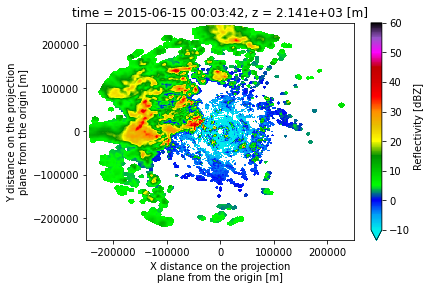

In [13]:
xg.REF[0,4].plot(cmap=cmap,vmin=vmin,vmax=vmax)

## Lets create a cappi using pyscancf

Generating Figures of Max-CAPPI, please be patient!
Figures saved


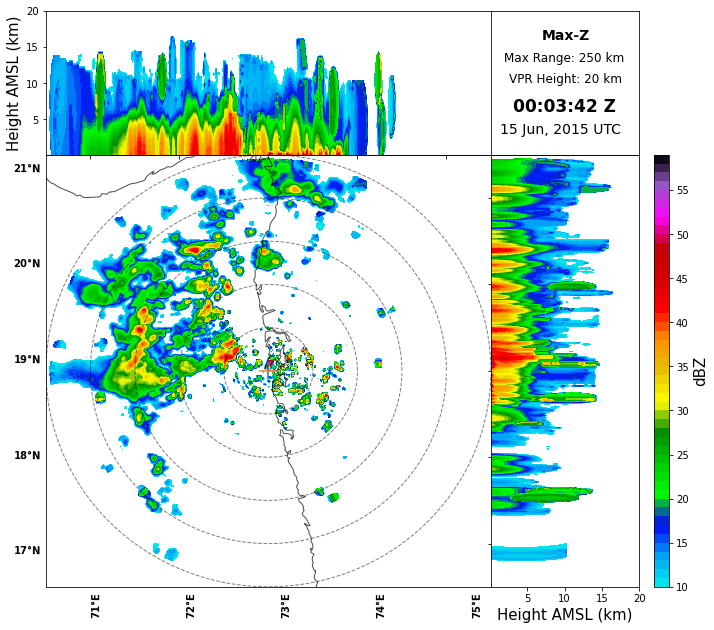

In [14]:
pcf.plot_cappi(grid,'REF')

### Lets analyze the polar file using wradlib

In [15]:
vol = wrl.io.open_cfradial1_dataset('output/polar_MUM150615000342.nc')

In [16]:
vol

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.2, 1.0, 2.0, 3.0, 4.5, 6.0, 9.0, 12.0, 16.0, 21.0)

In [17]:
swp = vol[0].pipe(wrl.georef.georeference_dataset)

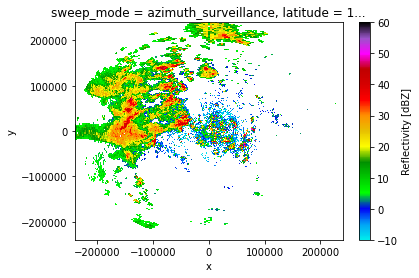

In [18]:
swp.where((swp.REF>-10)&(swp.REF<60)).REF.plot(x='x',cmap='pyart_NWSRef',vmin=-10,vmax=60,y='y')

### let's convert reflectivity to rain rate

#### First convert dbz to db

In [20]:
Z = wrl.trafo.idecibel(xg.REF[0,4])

In [21]:
rain = wrl.zr.z_to_r(Z,a = 200,b=1.6)#marshal palmer

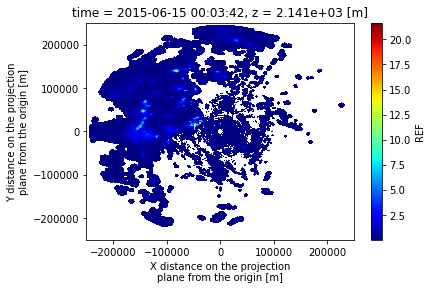

In [26]:
rain.plot(cmap='jet')